In [1]:
%load_ext lab_black
import os, sys

%load_ext autoreload
%autoreload 2

sys.path.append("/n/home12/khou/holystore/")

import matplotlib

matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

import paper_utils
import matplotlib.pyplot as plt
import scdrs.data_loader as dl
import pandas as pd
import numpy as np
from os.path import join
from statsmodels.stats.multitest import multipletests
from scipy.stats import rankdata
from tqdm import tqdm
from scipy import stats
from matplotlib.patches import Rectangle
import matplotlib.patches as patches

In [2]:
def small_squares(ax, pos, size=1, linewidth=0.8):
    """
    Draw many small squares on ax, given the positions of
    these squares.

    """
    for xy in pos:
        x, y = xy
        margin = (1 - size) / 2
        rect = patches.Rectangle(
            (x + margin, y + margin),
            size,
            size,
            linewidth=linewidth,
            edgecolor="k",
            facecolor="none",
            zorder=20,
        )
        ax.add_patch(rect)


def celltype_display_name(x):
    if x in dict_celltype_name:
        name = dict_celltype_name[x]
    else:
        name = x
    name += f" ({df_celltype_n_cell[x]})"
    name = name.replace("_", " ")
    name = name[0].upper() + name[1:]
    return name


def trait_display_name(x):
    dict_trait_name = {
        row.Trait_Identifier: row["Trait Name"] for _, row in df_trait_info.iterrows()
    }
    dict_trait_code = {
        row.Trait_Identifier: row["Code"] for _, row in df_trait_info.iterrows()
    }

    if dict_trait_name[x].lower() != dict_trait_code[x].lower():
        return f"{dict_trait_name[x]} ({dict_trait_code[x]})"
    else:
        return dict_trait_name[x]


def asterisk_display(x):
    if x < 0.05:
        return "×"
    else:
        return ""

In [3]:
# Setup file paths
DATA_PATH = "/n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data"
data_facs_ct = dl.load_tms_ct(DATA_PATH, data_name="facs")
df_hom = pd.read_csv(
    "/n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data/gene_annotation/"
    "mouse_human_homologs.txt",
    sep="\t",
)

SCORE_PATH = join(DATA_PATH, "score_file/score.tms_facs_with_cov.magma_10kb_1000")
URL_SUPP_TABLE = (
    "supp_tables.xlsx"
)


df_trait_info = pd.read_excel(
    URL_SUPP_TABLE,
    sheet_name=0,
)

df_celltype_info = pd.read_excel(
    URL_SUPP_TABLE,
    sheet_name=1,
)

/n/holystore01/LABS/price_lab/Users/khou/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2630: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/n/holystore01/LABS/price_lab/Users/khou/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2630: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Trying to set attribute `.obs` of view, copying.


In [4]:
df_fdr_prop1 = pd.read_csv("data/summary_ct/drs_fdr_prop.10kb.1000.csv", index_col=0)
df_fdr_prop2 = pd.read_csv("data/summary_ct/drs_fdr_prop.tms_facs.csv", index_col=0)
df_fdr_prop2 = df_fdr_prop2.loc[df_fdr_prop1.index, df_fdr_prop1.columns]
df_fdr_prop = df_fdr_prop2.copy()

# check sources of difference
df_gearysc_meta_fdr = pd.read_csv(
    "data/summary_ct/df_gearysc_fdr.tms_facs.csv", index_col=0
)

# Overview

In [ ]:
df_celltype_n_cell = data_facs_ct.obs.cell_ontology_class.value_counts()
df_celltype_n_cell.index = [
    c.replace(" ", "_").replace(",", "") for c in df_celltype_n_cell.index
]


dict_celltype_name = {
    row.id: row.code for _, row in df_celltype_info.iterrows() if not pd.isna(row.code)
}

df_plot = df_fdr_prop.copy()

df_ct_pval = pd.read_csv("data/summary_ct/df_pval.tms_facs.csv", index_col=0)
df_ct_fdr = pd.DataFrame(
    multipletests(df_ct_pval.values.flatten(), method="fdr_bh")[1].reshape(
        df_ct_pval.shape
    ),
    index=df_ct_pval.index,
    columns=df_ct_pval.columns,
)
df_ct_fdr = df_ct_fdr.loc[df_plot.index, df_plot.columns].copy()

df_gearysc_plot = df_gearysc_meta_fdr.loc[df_plot.index, df_plot.columns].copy()

df_gearysc_annot = df_gearysc_plot.applymap(asterisk_display)
df_gearysc_annot[df_ct_fdr > 0.05] = ""
df_plot[df_ct_fdr > 0.05] = 0.0

df_plot = df_plot.rename(index=trait_display_name, columns=celltype_display_name)

fig, ax = paper_utils.plot_heatmap(
    df_plot,
    squaresize=20,
    heatmap_annot=df_gearysc_annot,
    heatmap_annot_kws={"color": "black", "size": 4},
    heatmap_cbar_kws=dict(
        use_gridspec=False, location="top", fraction=0.03, pad=0.05, drawedges=True
    ),
    heatmap_vmin=0,
    heatmap_vmax=1,
    colormap_n_bin=10,
)

######### add small squares to show cell-type trait association ##########

small_squares(
    ax,
    pos=[(y, x) for x, y in zip(*np.where(df_ct_fdr < 0.05))],
    size=0.6,
    linewidth=0.5,
)

cb = ax.collections[0].colorbar
cb.ax.set_title("Prop. of sig. cells (FDR < 0.1)")
cb.outline.set_edgecolor("black")
cb.outline.set_linewidth(1)

# add diagonal boxes

x_seps = [
    df_trait_info.Category.isin(["blood/immune"]).sum(),
    df_trait_info.Category.isin(["brain"]).sum(),
    df_trait_info.Category.isin(["metabolic", "heart", "other"]).sum(),
]
y_seps = [
    df_celltype_info.category.isin(["blood", "immune"]).sum(),
    df_celltype_info.category.isin(["brain"]).sum(),
    df_celltype_info.category.isin(["others"]).sum(),
]
paper_utils.plot_diagonal_block(y_seps, x_seps, ax, linewidth=1.5)


dict_group_colors = {"Blood / immune": "C0", "Brain": "C1", "Others": "C2"}
# annotate cell-types
ct_breaks = np.cumsum([0] + y_seps)
for i, ct in enumerate(["Blood / immune", "Brain", "Others"]):
    paper_utils.annotation_line(
        ax=ax,
        text=ct,
        xy1=(ct_breaks[i], -0.2),
        xy2=(ct_breaks[i + 1], -0.2),
        text_offset_y=-1,
        linecolor=dict_group_colors[ct],
        text_color=dict_group_colors[ct],
        fontsize=12,
    )
    for label in ax.xaxis.get_ticklabels()[ct_breaks[i] : ct_breaks[i + 1]]:
        label.set_color(dict_group_colors[ct])

# annotate traits
trait_breaks = np.cumsum([0] + x_seps)
for i, trait in enumerate(["Blood / immune", "Brain", "Others"]):

    paper_utils.annotation_line(
        ax=ax,
        text=trait,
        xy1=(ct_breaks[-1] + 0.2, trait_breaks[i]),
        xy2=(ct_breaks[-1] + 0.2, trait_breaks[i + 1]),
        text_rotation=270,
        text_offset_x=1,
        linecolor=dict_group_colors[trait],
        text_color=dict_group_colors[trait],
        fontsize=12,
    )
    for label in ax.yaxis.get_ticklabels()[trait_breaks[i] : trait_breaks[i + 1]]:
        label.set_color(dict_group_colors[trait])


plt.savefig("results/celltype_assoc_detail.pdf", bbox_inches="tight")
plt.show()

In [11]:
print(
    f"Out of all {df_ct_fdr.shape[0] * df_ct_fdr.shape[1]} cell type disease pairs, {(df_ct_fdr <= 0.05).sum().sum()} significant, {(df_gearysc_annot == '×').sum().sum()} heterogenous"
)

print(
    f"{((df_ct_fdr < 0.05) & (df_gearysc_annot == '×')).any(axis=1).sum()} out of {(df_ct_fdr < 0.05).any(axis=1).sum()} traits with a critical cell type has a significant heterogeneity cell-type"
)

Out of all 8880 cell type disease pairs, 577 significant, 247 heterogenous
65 out of 74 traits with a critical cell type has a significant heterogeneity cell-type


In [13]:
df_ct_fdr_brain = df_ct_fdr.loc[
    df_trait_info.Category.isin(["brain"]).values,
    df_celltype_info.category.isin(["brain"]).values,
]
print(
    f"Number of brain cell types: {df_ct_fdr_brain.shape[1]}, number of brain traits: {df_ct_fdr_brain.shape[0]}"
)
print(
    f"Number of significant cell type trait pair: {(df_ct_fdr_brain < 0.05).sum().sum()}"
)

Number of brain cell types: 11, number of brain traits: 21
Number of significant cell type trait pair: 130


# Main figures

In [14]:
# Plot order for main figure
df_tmp = pd.read_excel(
    URL_SUPP_TABLE,
    sheet_name="fig3-display",
).dropna(how="all")

plot_order = dict()
for c, group in df_tmp.groupby("cluster"):
    plot_order[c] = (group.trait.dropna().values, group.celltype.dropna().values)

dict_trait_name = {
    row.Trait_Identifier: row["Code"] for _, row in df_trait_info.iterrows()
}

dict_celltype_name = {
    row.id: row.code for _, row in df_celltype_info.iterrows() if not pd.isna(row.code)
}


def trait_display_name(x):
    dict_trait_name = {
        row.Trait_Identifier: row["Trait Name"] for _, row in df_trait_info.iterrows()
    }
    dict_trait_code = {
        row.Trait_Identifier: row["Code"] for _, row in df_trait_info.iterrows()
    }

    if dict_trait_name[x].lower() != dict_trait_code[x].lower():
        display_name = f"{dict_trait_name[x]} ({dict_trait_code[x]})"
    else:
        display_name = dict_trait_name[x]

    # special case for RDW
    if dict_trait_code[x] == "RDW":
        return "RBC Distribution width (RDW)"
    return display_name

Number of traits / cell types in the analysis: (21, 20)
37 of 70 associations are heterogeneous


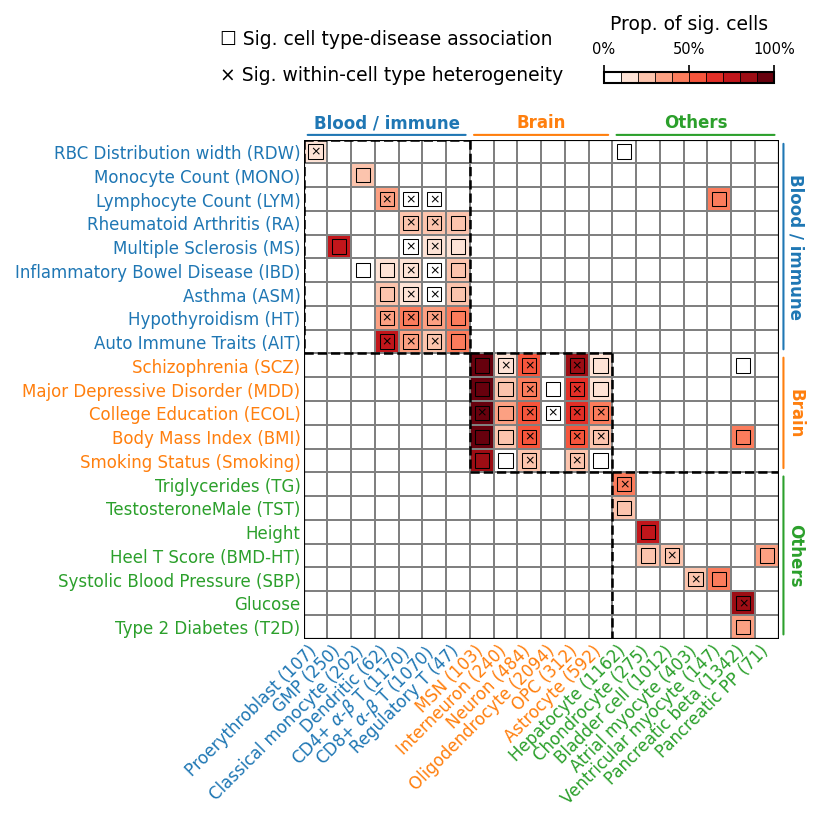

In [15]:
df_ct_pval = pd.read_csv("data/summary_ct/df_pval.tms_facs.csv", index_col=0)
df_ct_fdr = pd.DataFrame(
    multipletests(df_ct_pval.values.flatten(), method="fdr_bh")[1].reshape(
        df_ct_pval.shape
    ),
    index=df_ct_pval.index,
    columns=df_ct_pval.columns,
)

df_ct_fdr = df_ct_fdr.loc[
    np.concatenate([plot_order[c][0] for c in plot_order]),
    np.concatenate([plot_order[c][1] for c in plot_order]),
]


df_plot = df_fdr_prop.loc[
    np.concatenate([plot_order[c][0] for c in plot_order]),
    np.concatenate([plot_order[c][1] for c in plot_order]),
].copy()
print("Number of traits / cell types in the analysis:", df_plot.shape)
# add diagonal boxes
x_seps = [len(plot_order[c][0]) for c in plot_order]
y_seps = [len(plot_order[c][1]) for c in plot_order]

df_gearysc_plot = df_gearysc_meta_fdr.loc[df_plot.index, df_plot.columns].copy()

df_gearysc_annot = df_gearysc_plot.applymap(asterisk_display)
df_gearysc_annot[(df_ct_fdr > 0.05)] = ""

df_plot[df_ct_fdr > 0.05] = 0.0
df_plot = df_plot.rename(index=trait_display_name, columns=celltype_display_name)

print(
    f"{np.sum(df_gearysc_annot == '×').sum()} of {np.sum(df_ct_fdr <= 0.05).sum()} associations are heterogeneous"
)

fig, ax = paper_utils.plot_heatmap(
    df_plot,
    squaresize=27,
    heatmap_annot=df_gearysc_annot,
    heatmap_annot_kws={"color": "black", "size": 6},
    heatmap_xticklabels=True,
    heatmap_yticklabels=True,
    heatmap_linecolor="gray",
    heatmap_linewidths=0.05,
    heatmap_cbar_kws=dict(
        use_gridspec=False,
        location="top",
        fraction=0.02,
        pad=0.1,
        drawedges=True,
        anchor=(0.9, 1.0),
        aspect=15,
    ),
    heatmap_vmin=0,
    heatmap_vmax=1.0,
    colormap_n_bin=10,
)

small_squares(
    ax,
    pos=[(y, x) for x, y in zip(*np.where(df_ct_fdr < 0.05))],
    size=0.6,
    linewidth=0.5,
)
cb = ax.collections[0].colorbar
cb.outline.set_edgecolor("black")
cb.outline.set_linewidth(1)
cb.ax.set_title("Prop. of sig. cells", fontsize=9)
cb.set_ticks([0, 0.5, 1.0])
cb.ax.set_xticklabels(["0%", "50%", "100%"], size=7)
# add bounding box

for x in ax.get_xlim():
    ax.axvline(x=x, color="k", linewidth=1)
    ax.axvline(x=x, color="k", linewidth=1)

for y in ax.get_ylim():
    ax.axhline(y=y, color="k", linewidth=1)
    ax.axhline(y=y, color="k", linewidth=1)


paper_utils.plot_diagonal_block(y_seps, x_seps, ax, linewidth=1.2)

dict_group_colors = {"Blood / immune": "C0", "Brain": "C1", "Others": "C2"}
# annotate cell-types
ct_breaks = np.cumsum([0] + y_seps)
for i, ct in enumerate(["Blood / immune", "Brain", "Others"]):
    paper_utils.annotation_line(
        ax=ax,
        text=ct,
        xy1=(ct_breaks[i], -0.2),
        xy2=(ct_breaks[i + 1], -0.2),
        text_offset_y=-0.5,
        linecolor=dict_group_colors[ct],
        text_color=dict_group_colors[ct],
    )
    for label in ax.xaxis.get_ticklabels()[ct_breaks[i] : ct_breaks[i + 1]]:
        label.set_color(dict_group_colors[ct])

# annotate traits
trait_breaks = np.cumsum([0] + x_seps)
for i, trait in enumerate(["Blood / immune", "Brain", "Others"]):

    paper_utils.annotation_line(
        ax=ax,
        text=trait,
        xy1=(ct_breaks[-1] + 0.2, trait_breaks[i]),
        xy2=(ct_breaks[-1] + 0.2, trait_breaks[i + 1]),
        text_rotation=270,
        text_offset_x=0.5,
        linecolor=dict_group_colors[trait],
        text_color=dict_group_colors[trait],
    )
    for label in ax.yaxis.get_ticklabels()[trait_breaks[i] : trait_breaks[i + 1]]:
        label.set_color(dict_group_colors[trait])

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

plt.text(-3.5, -4, "☐ Sig. cell type-disease association", fontsize=9)
plt.text(-3.5, -2.5, "× Sig. within-cell type heterogeneity", fontsize=9)


plt.savefig("results/celltype_assoc_overview.pdf", bbox_inches="tight")

In [ ]:
df_ct_pval = pd.read_csv("data/summary_ct/df_pval.tms_facs.csv", index_col=0)
df_plot_fdr = pd.DataFrame(
    multipletests(df_ct_pval.values.flatten(), method="fdr_bh")[1].reshape(
        df_ct_pval.shape
    ),
    index=df_ct_pval.index,
    columns=df_ct_pval.columns,
)

df_plot = df_ct_pval.loc[
    np.concatenate([plot_order[c][0] for c in plot_order]),
    np.concatenate([plot_order[c][1] for c in plot_order]),
].copy()

df_plot_fdr = df_plot_fdr.loc[df_plot.index, df_plot.columns]
df_plot_fdr = df_plot_fdr.rename(index=trait_display_name)


def signif_display(x):
    if x < 0.05:
        return "*"
    else:
        return ""


df_plot_annot = df_plot_fdr.applymap(signif_display)
df_plot = -np.log10(df_plot)
df_plot = df_plot.rename(index=trait_display_name, columns=celltype_display_name)


print("Number of traits / cell types in the analysis:", df_plot.shape)
# add diagonal boxes
x_seps = [len(plot_order[c][0]) for c in plot_order]
y_seps = [len(plot_order[c][1]) for c in plot_order]


fig, ax = paper_utils.plot_heatmap(
    df_plot,
    squaresize=27,
    heatmap_annot=df_plot_annot,
    heatmap_annot_kws={"color": "black", "size": 6},
    heatmap_xticklabels=True,
    heatmap_yticklabels=True,
    heatmap_linecolor="gray",
    heatmap_linewidths=0.05,
    heatmap_cbar_kws=dict(
        use_gridspec=False, location="top", fraction=0.02, pad=0.08, drawedges=True
    ),
    heatmap_vmin=0,
    heatmap_vmax=4.0,
    colormap_n_bin=10,
)


cb = ax.collections[0].colorbar
cb.outline.set_edgecolor("black")
cb.outline.set_linewidth(1)
cb.ax.set_title("scDRS cell-type -$\log_{10}(p)$", fontsize=9)

# add bounding box

for x in ax.get_xlim():
    ax.axvline(x=x, color="k", linewidth=1)
    ax.axvline(x=x, color="k", linewidth=1)

for y in ax.get_ylim():
    ax.axhline(y=y, color="k", linewidth=1)
    ax.axhline(y=y, color="k", linewidth=1)


paper_utils.plot_diagonal_block(y_seps, x_seps, ax, linewidth=1.2)

dict_group_colors = {"Blood / immune": "C0", "Brain": "C1", "Others": "C2"}
# annotate cell-types
ct_breaks = np.cumsum([0] + y_seps)
for i, ct in enumerate(["Blood / immune", "Brain", "Others"]):
    paper_utils.annotation_line(
        ax=ax,
        text=ct,
        xy1=(ct_breaks[i], -0.2),
        xy2=(ct_breaks[i + 1], -0.2),
        text_offset_y=-0.5,
        linecolor=dict_group_colors[ct],
        text_color=dict_group_colors[ct],
    )
    for label in ax.xaxis.get_ticklabels()[ct_breaks[i] : ct_breaks[i + 1]]:
        label.set_color(dict_group_colors[ct])

# annotate traits
trait_breaks = np.cumsum([0] + x_seps)
for i, trait in enumerate(["Blood / immune", "Brain", "Others"]):

    paper_utils.annotation_line(
        ax=ax,
        text=trait,
        xy1=(ct_breaks[-1] + 0.2, trait_breaks[i]),
        xy2=(ct_breaks[-1] + 0.2, trait_breaks[i + 1]),
        text_rotation=270,
        text_offset_x=0.5,
        linecolor=dict_group_colors[trait],
        text_color=dict_group_colors[trait],
    )
    for label in ax.yaxis.get_ticklabels()[trait_breaks[i] : trait_breaks[i + 1]]:
        label.set_color(dict_group_colors[trait])

plt.savefig("results/celltype_assoc_pval_overview.pdf", bbox_inches="tight")

Number of traits / cell types in the analysis: (21, 20)
